In [16]:
import sys
sys.path[0] = '../'

In [17]:
sys.argv  = 'train.py --version tmp --model_name resnet18'.split()
# sys.argv  = 'train.py --version tmp'.split()

In [32]:
save_path = '../save/0007_20210709_small_resnet18_centercrop_pretrained//model/model.pth'

In [33]:
from sklearn.metrics import confusion_matrix

In [34]:
import torch
import torch.nn as nn

from models import get_model
from optimizer import get_optimizer
from dataset import get_dataloader

import argparse
import utils
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt

def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--version", type=str, required=True)
    # dataset

    # learning hyperparameter
    parser.add_argument("--lr", type=int, default=1e-4, help='')
    parser.add_argument("--batch_size", type=int, default=32, help='')
    parser.add_argument("--epoch", type=int, default=100000, help='')
    parser.add_argument("--eval_epoch", type=int, default=5, help='')
    # model hyperparameter
    parser.add_argument("--model_name", type=str, default='rexnetv1-1.0', choices=['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'rexnetv1-1.0', 'rexnetv1-1.3', 'rexnetv1-1.5', 'rexnetv1-2.0', 'rexnetv1-3.0'])
    parser.add_argument("--pretrained", action='store_true', default=False, help='')
    parser.add_argument("--optimizer_name", type=str, default='Adam', choices=['Adam'])
    # etc
    parser.add_argument("--print_cycle", type=int, default=50, help='')
    parser.add_argument("--seed", type=int, default=42, help='')
    parser.add_argument("--n_class", type=int, default=5)

    args = parser.parse_args()
    return args

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)



In [35]:
args = parse_args()
set_seed(args.seed)

In [36]:
args.pretrained = False
model = get_model(args)

model.load_state_dict(torch.load(save_path)['model'])

model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [37]:
test_dataloader = get_dataloader(batch_size = args.batch_size, split='test')

In [38]:
preds = []
labels = []
with torch.no_grad():
    model.eval()
    for (x,y) in test_dataloader:
        x = x.cuda()
        y = y.cuda()

        out = model(x)
        
        preds.append(out.data.cpu())
        labels.append(y.data.cpu())
preds = torch.cat(preds)
labels = torch.cat(labels)

In [39]:
preds = preds.softmax(1)

In [40]:
torch.mean((preds.argmax(1) == labels).float())

tensor(0.7319)

In [41]:
import itertools
def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
    
    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [42]:
new_pred = preds.argmax(1).clone()
new_label = labels.clone()

In [43]:
new_pred[new_pred==4] = 3
new_label[new_label==4] = 3

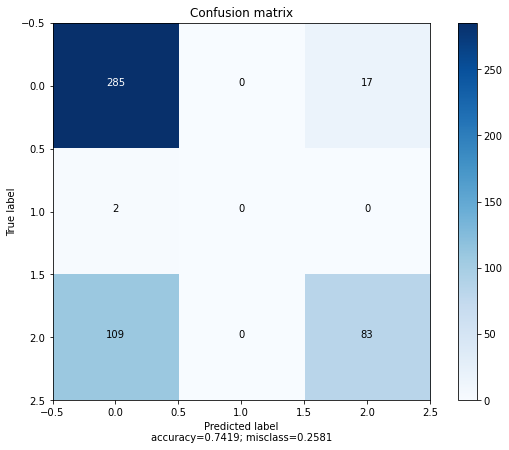

In [44]:
cm = confusion_matrix(y_true=new_label, y_pred=new_pred)
plot_confusion_matrix(cm,normalize=False)

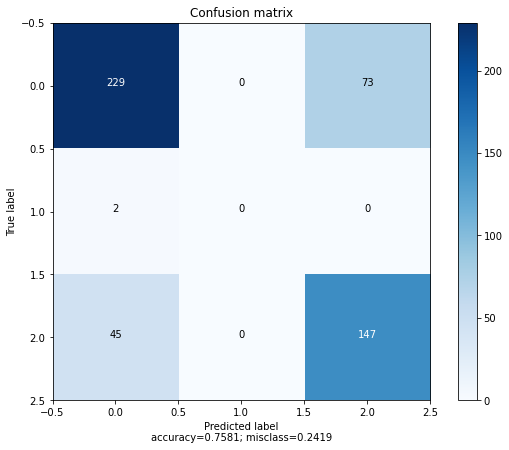

In [46]:
cm = confusion_matrix(y_true=new_label, y_pred=new_pred)
plot_confusion_matrix(cm,normalize=False)

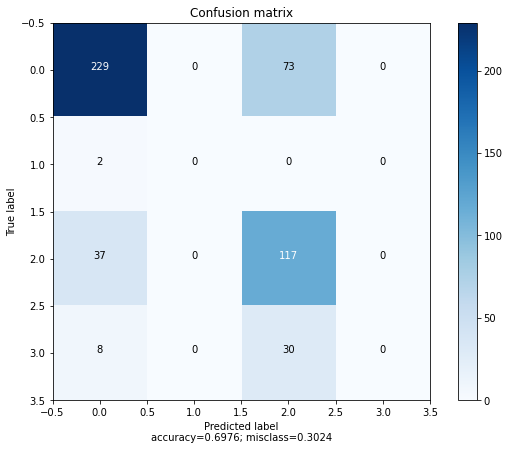

In [35]:
cm = confusion_matrix(y_true=labels, y_pred=preds.argmax(1))
plot_confusion_matrix(cm,normalize=False)

# GradCAM

https://github.com/jacobgil/pytorch-grad-cam

In [46]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import os 

target_layer = model.layer4[-1] #resnet
# target_layer = model.features[18] #rexnet
cam = GradCAM(model=model, target_layer=target_layer, use_cuda=True)
cam_save_path = '../save/0007_20210709_small_resnet18_centercrop_pretrained//images/GradCAM2/'
os.makedirs(cam_save_path, exist_ok=True)

for idx, (x,y) in enumerate(test_dataloader):
        input_tensor = x.cuda()
        with torch.no_grad():
            pred_prob = model(input_tensor).softmax(1)
            pred = pred_prob.argmax(1)         
        
        cams = []
        for c in range(5):
            target_category = c
            grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)
            cams.append(grayscale_cam)

        for i in range(len(x)):
            visualizations = []
            for c in range(5):
                visualization = show_cam_on_image(input_tensor[i].permute(1,2,0).data.cpu().numpy(), cams[c][i])
                visualizations.append(visualization)
            
            # show
            plt.figure(figsize=(20,15))
            plt.subplot(2,3,1)
            plt.imshow(input_tensor[i].permute(1,2,0).data.cpu())
            plt.title('Input image')
            for c in range(5):
                plt.subplot(2,3,2+c)
                plt.imshow(visualizations[c])
                plt.title('Pred: {} / Label: {} / Confidence: {:.3f} '.format(c, y[i],  pred_prob[i,c]))
            
            plt.savefig(os.path.join(cam_save_path,'label_{}_pred_{}_conf_{:.3f}.png'.format(y[i],pred[i],pred_prob[i,pred[i]])))
            plt.close()

/home/jg/miniconda3/envs/cac/lib/python3.9/site-packages/pytorch_grad_cam/base_cam.py:85: RuntimeWarning: invalid value encountered in true_divide
  img = img / np.max(img)
